# Census Shape Files and Hospital Distances

Our first step was to bring in census tract shape data as well as geocoded hospital addresses to measure the distance from each tract to the nearest hospital.

We will need the census tract shapefiles from the census and the geocoded hospital locations from CMS compare site.

Additionally, we will need to use a county fips code to county name crosswalk in order to simplify merges involving demographic and health outcomes data later.

First, importing packages and bringing in the data:

In [35]:
%matplotlib inline
import pandas as pd
import geopandas as gpd
import shapely.wkt
import statsmodels.formula.api as smf
import numpy as np
import matplotlib.patches as mpatches

In [36]:
# tracts data
al = gpd.read_file("cb_2016_01_tract_500k.shp") # Alabama
ms = gpd.read_file("cb_2016_28_tract_500k.shp") # Mississippi
mt = gpd.read_file("cb_2016_30_tract_500k.shp") # Montana
la = gpd.read_file("cb_2016_22_tract_500k.shp") # Louisiana
nd = gpd.read_file("cb_2016_38_tract_500k.shp") # North Dakota
sd = gpd.read_file("cb_2016_46_tract_500k.shp") # South Dakota
temp = al.append(ms)
temp1 = temp.append(mt)
temp2 = temp1.append(la)
temp3 = temp2.append(nd)
tracts = temp3.append(sd)

# hospital location data

points1 = pd.read_csv('points1.csv', usecols = ['location_state', 'location'])

# County fips to county name crosswalk
county_crosswalk = pd.read_csv('cbsatocountycrosswalk2016.csv', names = ['countyname', 'state', 'ssacounty', 'COUNTYFP', 'cbsa', 'cbsaname', 'ssast', 'STATEFP'])


We eventually want a column in our tracts dataframe of the form "county name, state name"

We will create this column in the crosswalk and merge it into the tracts dataframe.

Additionally, the county crosswalk has a few county names that don't precisely match up with the names in our demographics and health outcomes data later. We will make some corrections.

In [37]:
# Setting county fp code and state fp code to integers for when merging to county crosswalk
tracts['COUNTYFP'] = tracts['COUNTYFP'].astype(int)
tracts['STATEFP'] = tracts['STATEFP'].astype(int)

# Mapping State and County Fips to County Name

county_crosswalk = pd.read_csv('cbsatocountycrosswalk2016.csv', names = ['countyname', 'state', 'ssacounty', 'COUNTYFP', 'cbsa', 'cbsaname', 'ssast', 'STATEFP'])


# demographic data is indexed by "countyname, statename"
county_crosswalk['index1'] = county_crosswalk['countyname'] + ", " + county_crosswalk['state']


# Some counties have different spellings in the ACS data, we will change this crosswalk to account for the difference
badlist = ['Jeffrson Davis County, Louisiana', 'E. Baton Rouge County, Louisiana',
           'De Kalb County, Alabama', 'De Soto County, Mississippi', 'La Moure County, North Dakota',
           'La Salle County, Louisiana','Oglala Lakota, South Dakota','Mc Cook County, South Dakota',
           'Mc Pherson County, South Dakota', 'Mccone County, Montana', 'Mchenry County, North Dakota',
           'Mcintosh County, North Dakota', 'Mckenzie County, North Dakota', 'Mclean County, North Dakota',
           'St. John Baptist County, Louisiana', 'W. Baton Rouge County, Louisiana', 'Lewis And Clark County, Montana']

goodlist = ['Jefferson Davis County, Louisiana', 'East Baton Rouge County, Louisiana',
           'DeKalb County, Alabama', 'DeSoto County, Mississippi', 'LaMoure County, North Dakota',
           'LaSalle County, Louisiana','Oglala Lakota County, South Dakota','McCook County, South Dakota',
           'McPherson County, South Dakota', 'McCone County, Montana', 'McHenry County, North Dakota',
           'McIntosh County, North Dakota', 'McKenzie County, North Dakota', 'McLean County, North Dakota',
           'St. John the Baptist County, Louisiana', 'West Baton Rouge County, Louisiana', 'Lewis and Clark County, Montana']

dictionary = dict(zip(badlist, goodlist))

as_list = county_crosswalk['index1'].tolist()

for x in badlist:
    idx = as_list.index(x)
    as_list[idx] = dictionary[x]
    
county_crosswalk['index1'] = as_list

# bringing the crosswalk into the census tracts data
tracts = pd.merge(tracts, county_crosswalk, on = ['STATEFP', 'COUNTYFP'])

Ok, now onwards to the hospital data!

The hospital data is not read in as a geopandas series and must be interpreted as geographical data. Additionally we want both sets of data, the tracts and hospital points, to be read as Alber's Equal Area projection coordinates.

We will also restrict the information to hospitals within our states of interest

In [38]:
# Moving tracts from Plate Caree to Albers Equal Area 
tracts = tracts.to_crs(epsg = 2163)

# Read in hospital locations
points1 = pd.read_csv('points1.csv', usecols = ['location_state', 'location'])

# Restrict to states of interest
statelist = ['AL', 'LA', 'MS', 'ND', 'SD', 'MT']
points1 = points1[points1['location_state'].isin(statelist)]

# pull out just the string geocodes
locations = points1['location']

# convert to geoseries and reindex
geometry = locations.map(shapely.wkt.loads)
crs = {'init': 'epsg:4269'}
locations = gpd.GeoDataFrame(locations, crs=crs, geometry=geometry).to_crs(epsg = 2163)
locations.index = range(len(locations.index))


Now, armed with correctly formatted geographical data, we can calculate the distance from the centroid of each tract to the nearest hospital, but first let's just enjoy a map of our data (and make sure it worked correctly):

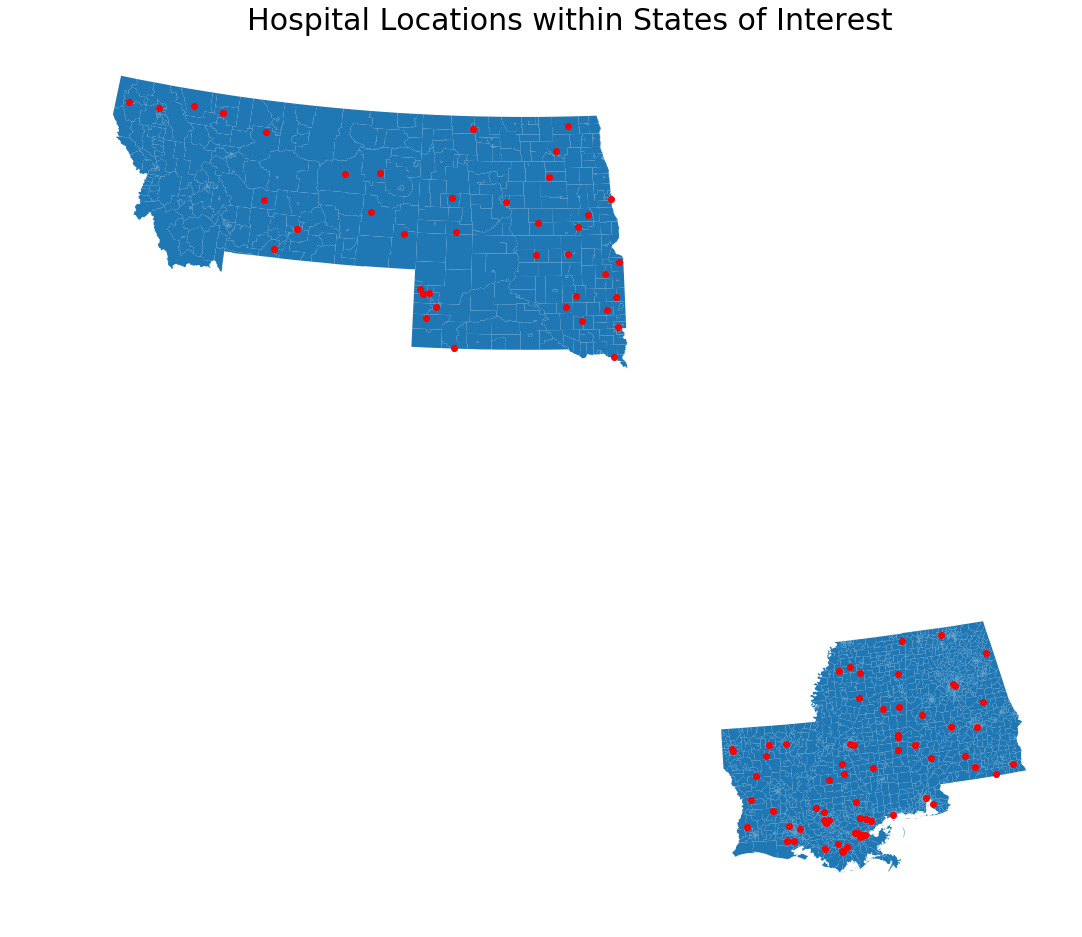

In [110]:
ax = tracts.plot(figsize=(18,18))
ax.set_title('Hospital Locations within States of Interest', size=30)
locations.plot(ax = ax, figsize=(18,18), color='red').set_axis_off()

Great! Now let's write a function that finds the distance from each census tract centroid to the nearest hospital. We'll draw another graph to make sure it worked:

In [40]:
# Credit to Jamie for the merge_closest function. Thanks Jamie!

def merge_closest(adf, bdf):

    adf["mindist"] = float('nan')

    for ri, row in adf.iterrows():
        ctr = row.geometry.centroid
        distances = [(xi, pt.distance(ctr)) for xi, pt in enumerate(bdf.geometry)]
        mindist = min(distances, key=lambda item:item[1])[1]
        mindist = mindist
        adf.loc[ri, "mindist"] = mindist/1000
        if (ri % 100) == 0: print(ri, end = " ") # Just to give some pulse/output...
            
    print()

merge_closest(tracts, locations)

0 100 200 300 400 500 600 700 800 900 1000 1100 1200 1300 1400 1500 1600 1700 1800 1900 2000 2100 2200 2300 2400 2500 2600 2700 2800 2900 3000 3100 3200 3300 3400 3500 3600 


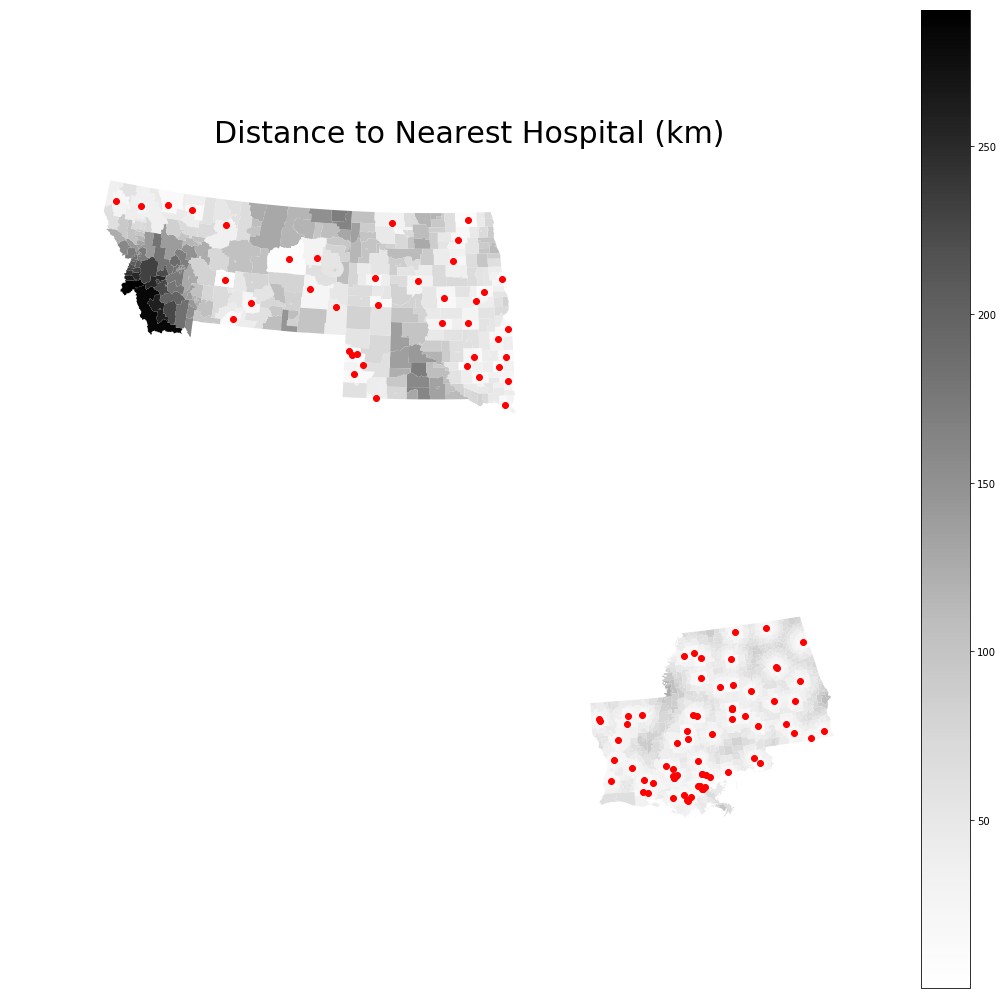

In [105]:
# testing to make sure everything worked
ax = tracts.plot(column = 'mindist', cmap = "Greys", figsize=(18,18), legend = True)
ax.set_title('Distance to Nearest Hospital (km)', size = 30)
ax1 = locations.plot(ax = ax,figsize=(18,18), color='red').set_axis_off()

Alright, looking great!

Now, since the rest of our data is going to be at the county level, we're going to aggregate up to the county level and then move on to the health outcomes and demographic data.

In [42]:
# Aggregrating to County Level and fixing some county names
counties = tracts.groupby("index1").mean()

# Health Outcomes

Our health outcomes data comes from CDC Wonder. The all cause mortality data is comprehensive. However, data regarding particular causes of death is fragmentary and not available for many small counties. First, let's read in the Wonder data:

In [43]:
# Reading in the cause specific health outcomes data rate in deaths/100000

LAHO = pd.read_csv('LA_HealthOutcomes.csv')
ALHO = pd.read_csv('ALHealthOutcomes.csv')
MSHO = pd.read_csv('MS_HealthOutcomes.csv')
MTHO = pd.read_csv('MT_HealthOutcomes.csv')
NDHO = pd.read_csv('ND_HealthOutcomes.csv')
SDHO = pd.read_csv('SD_HealthOutcomes.csv')




# Reading in the cause specific health outcomes data rate in deaths/100000

allcausemort = pd.read_csv("All Cause Mortality.csv", index_col = "County", usecols = ["County","Crude Rate"])
allcausemort["Crude Rate"] = allcausemort["Crude Rate"].astype(float)

For the cause specific data, we will mask out our causes of interest, then we will aggregate to the county level, and finally stitch the data from the states together into a single dataframe for each cause of interest.

In [44]:
# Defining masks based on cause of death

heartmask = ['Congestive heart failure', 'Atherosclerotic heart disease', 'Heart failure, unspecified',
             'Hypertensive heart disease without (congestive) heart failure',
             'Heart disease, unspecified', 'Chronic ischaemic heart disease, unspecified']
alzheimersmask = ["Alzheimer's disease, unspecified"]

# Masking out the causes of interest

LAHOH = LAHO[LAHO['Cause of death'].isin(heartmask)]
ALHOH = ALHO[ALHO['Cause of death'].isin(heartmask)]
MSHOH = MSHO[MSHO['Cause of death'].isin(heartmask)]
MTHOH = MTHO[MTHO['Cause of death'].isin(heartmask)]
NDHOH = NDHO[NDHO['Cause of death'].isin(heartmask)]
SDHOH = SDHO[SDHO['Cause of death'].isin(heartmask)]

LAHOA = LAHO[LAHO['Cause of death'].isin(alzheimersmask)]
ALHOA = ALHO[ALHO['Cause of death'].isin(alzheimersmask)]
MSHOA = MSHO[MSHO['Cause of death'].isin(alzheimersmask)]
MTHOA = MTHO[MTHO['Cause of death'].isin(alzheimersmask)]
NDHOA = NDHO[NDHO['Cause of death'].isin(alzheimersmask)]
SDHOA = SDHO[SDHO['Cause of death'].isin(alzheimersmask)]

# Aggregating to the county level

groupedLAH = LAHOH.groupby('County')['Crude Rate'].sum()
groupedALH = ALHOH.groupby('County')['Crude Rate'].sum()
groupedMSH = MSHOH.groupby('County')['Crude Rate'].sum()
groupedMTH = MTHOH.groupby('County')['Crude Rate'].sum()
groupedNDH = NDHOH.groupby('County')['Crude Rate'].sum()
groupedSDH = SDHOH.groupby('County')['Crude Rate'].sum()

groupedLAA = LAHOA.groupby('County')['Crude Rate'].sum()
groupedALA = ALHOA.groupby('County')['Crude Rate'].sum()
groupedMSA = MSHOA.groupby('County')['Crude Rate'].sum()
groupedMTA = MTHOA.groupby('County')['Crude Rate'].sum()
groupedNDA = NDHOA.groupby('County')['Crude Rate'].sum()
groupedSDA = SDHOA.groupby('County')['Crude Rate'].sum()


# Appending the data together

temp = groupedLAH.append(groupedALH)
temp1 = temp.append(groupedMSH)
temp2 = temp1.append(groupedMTH)
temp3 = temp2.append(groupedNDH)
health_outcomes_heart = temp3.append(groupedSDH)

temp = groupedLAA.append(groupedALA)
temp1 = temp.append(groupedMSA)
temp2 = temp1.append(groupedMTA)
temp3 = temp2.append(groupedNDA)
health_outcomes_A = temp3.append(groupedSDA)

Now we're in a position to see where we have data and where we don't. We can see that the length of our counties dataframe from above is 388, the number of counties in these 6 states.

We see that we have the proper number of entries in our all cause dataframe (the extra line is for deaths not matched to a county) but are missing data for many counties in the other two dataframes.

In [45]:
print(len(counties),
len(allcausemort),
len(health_outcomes_heart),
len(health_outcomes_A))

388 389 195 174


Let's see where we have data on a map. We'll merge these data with our tracts dataframe from earlier, create a boolean for where we have data present and graph it.

In [46]:
# Setting tracts index to match other data
tracts.set_index('index1', inplace = True)

# Defining booleans for mortality data presence

tracts_allcause = tracts.join(allcausemort, how = 'left')
tracts_allcause['datapresent'] = ~pd.isnull(tracts_allcause['Crude Rate'])

tracts_heart = tracts.join(health_outcomes_heart, how = 'left')
tracts_heart['datapresent'] = ~pd.isnull(tracts_heart['Crude Rate'])

tracts_A = tracts.join(health_outcomes_A, how = 'left')
tracts_A['datapresent'] = ~pd.isnull(tracts_A['Crude Rate'])

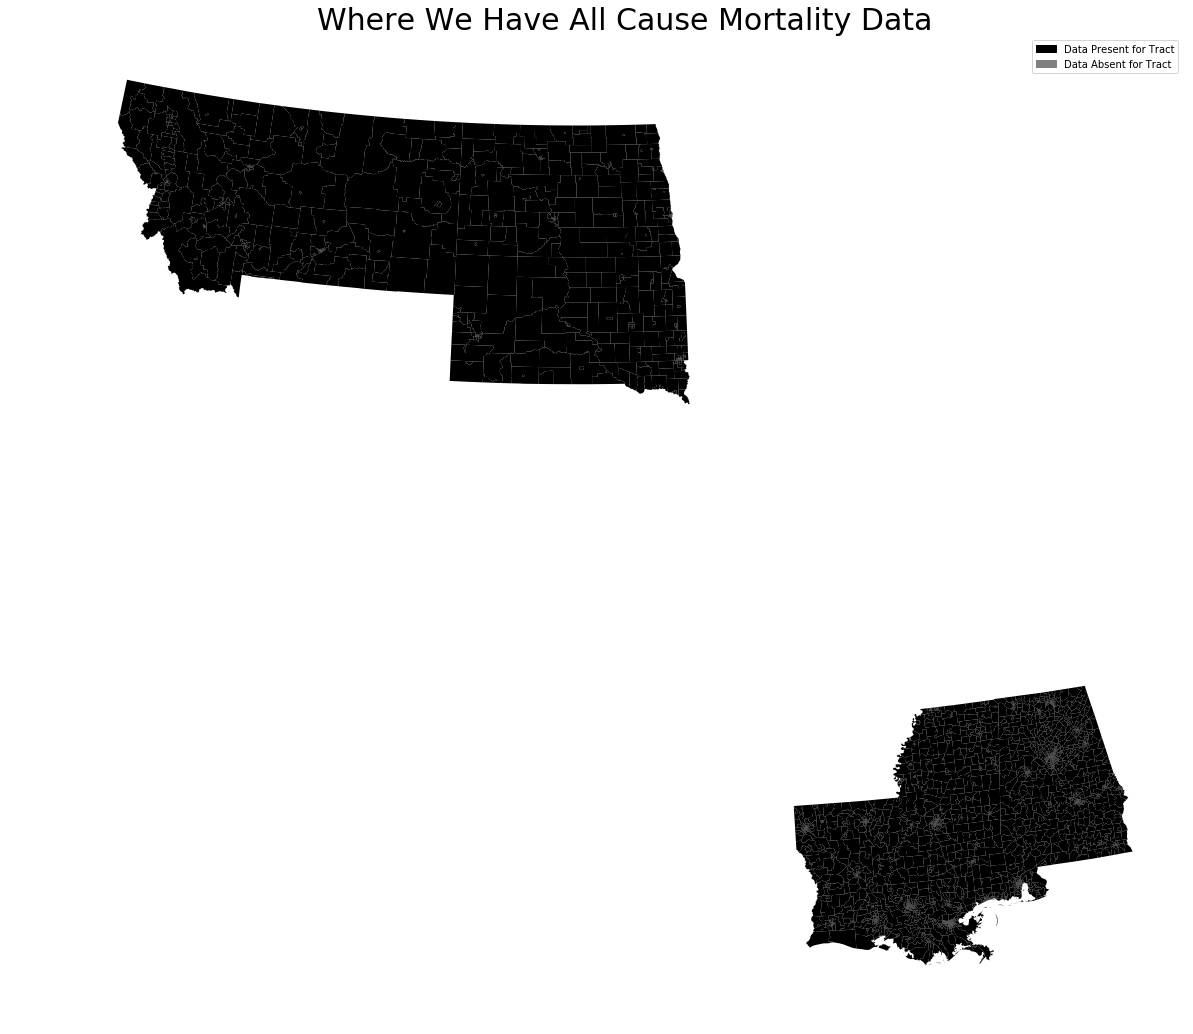

In [106]:
allpresent = tracts_allcause[tracts_allcause['datapresent'] == True] # Where do we have all cause mortality data?
heartpresent = tracts_heart[tracts_heart['datapresent'] == True] # Where do we have heart mortality data?
Apresent = tracts_A[tracts_A['datapresent'] == True] # Where do we have alzheimer's mortality data?

heartabsent = tracts_heart[tracts_heart['datapresent'] == False] # Where do we not have heart mortality data?
Aabsent = tracts_A[tracts_A['datapresent'] == False] # Where do we not have alzheimer's mortality data?

# Since "allabsent" will be an empty data frame (we have data everywhere for all cause mortality) we don't need to
# construct it.

# Just some extra stuff for a figure legend
black_patch = mpatches.Patch(color='black', label='Data Present for Tract')
grey_patch = mpatches.Patch(color='grey', label='Data Absent for Tract')


# Drawing the all cause figure
ax = allpresent.plot(color = "black", figsize=(20,20))
ax.set_axis_off()
ax.legend(handles=[black_patch, grey_patch])
ax.set_title('Where We Have All Cause Mortality Data', size = 30)

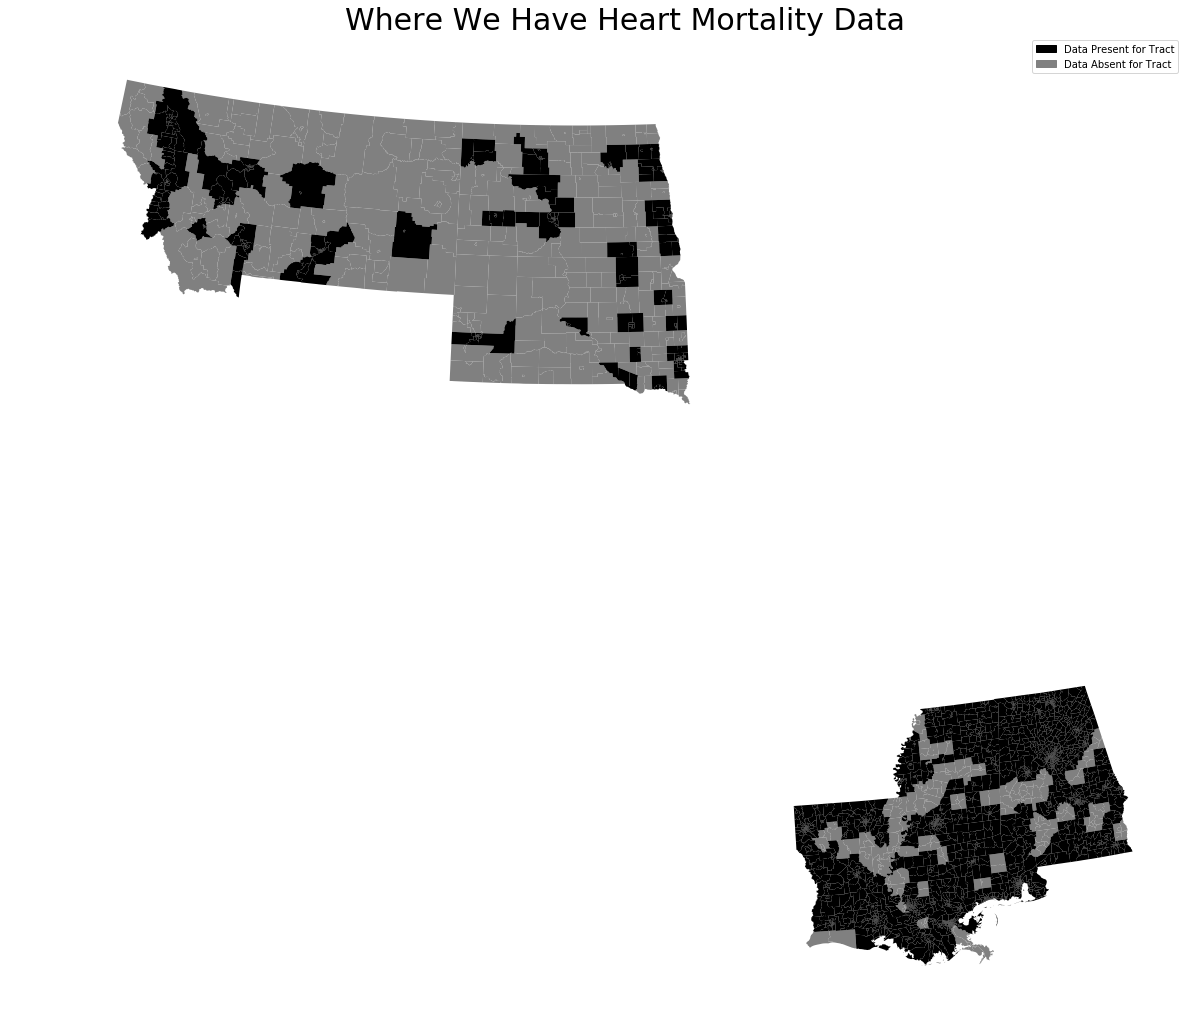

In [107]:
ax1 = heartabsent.plot(figsize=(20,20), color = 'grey')
ax2 = heartpresent.plot(ax = ax1, figsize=(20,20), color = "black")
ax2.legend(handles=[black_patch, grey_patch])
ax2.set_axis_off()
ax2.set_title('Where We Have Heart Mortality Data', size = 30)

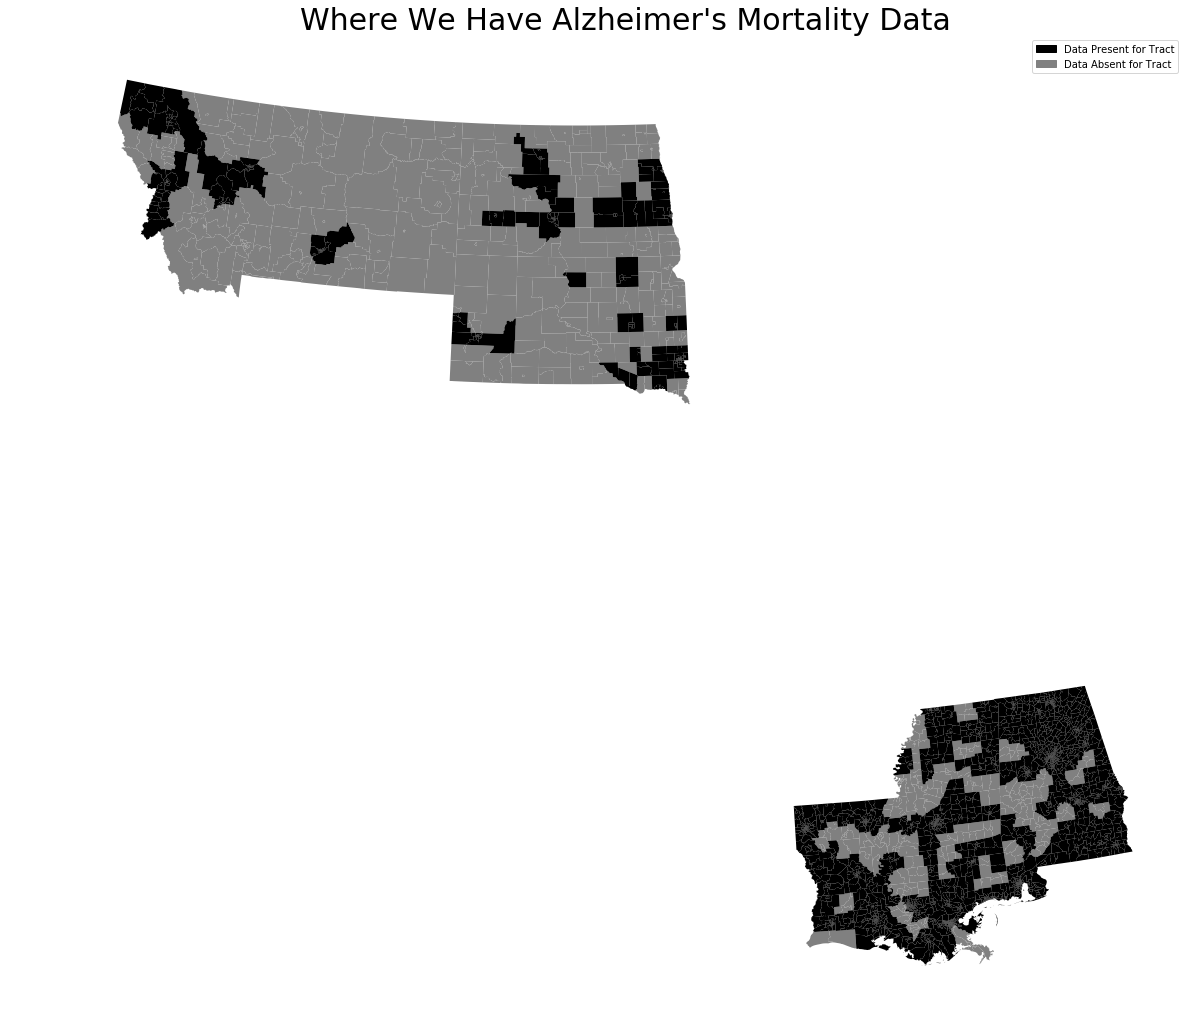

In [108]:
ax1 = Aabsent.plot(figsize=(20,20), color = 'grey')
ax2 = Apresent.plot(ax = ax1, figsize=(20,20), color = "black")
ax2.legend(handles=[black_patch, grey_patch])
ax2.set_axis_off()
ax2.set_title('Where We Have Alzheimer\'s Mortality Data', size = 30)

Unfortunately, data is highly fragmentary for the "by cause" mortality data, particular in the northern plains states.

However, we'll make the most of what we have. Before we begin running regressions we'll have to bring in our demographic data from the ACS

# Demographic Data from ACS

We pulled a number of different variables from the ACS in different .csv files. First we'll read them in and join them together:

In [50]:
# Importing and merging demographic data

education = pd.read_csv('Education by county.csv', index_col = 'Geography')
income = pd.read_csv('Median Income by County.csv', index_col = 'Geography')
sex = pd.read_csv('Sex by County.csv', index_col = 'County')
race = pd.read_csv('Percent nonhispanic white by county.csv', index_col = 'County')
unemployment = pd.read_csv('Unemployment by county.csv', index_col = 'Geography')
age = pd.read_csv('Percent over 65 by county.csv', index_col = 'County')


temp1 = education.join(income)
temp2 = temp1.join(sex)
temp3 = temp2.join(race)
temp4 = temp3.join(age)
demographics = temp4.join(unemployment)

len(demographics)

384

As seen above, there are four counties missing from the demographic data. These are four counties in North Dakota, which we'll see below.

Next, we'll need to join it, along with our outcomes data, to our "counties" data frame from earlier.

In [51]:
demographics_and_distance = counties.join(demographics, how = 'left')

#Seeing where we're missing data
demographics_and_distance[pd.isnull(demographics_and_distance['lessthanhighschool'])] # Counties with missing demographics

,STATEFP,COUNTYFP,ALAND,AWATER,ssacounty,cbsa,ssast,mindist,lessthanhighschool,ged,highschool,somecollege,associates,bachelor,graduateplus,Household Median Income,Percent Male,Percent non-hispanic White,Percent over 65,Unemployment rate; Estimate; Population 16 years and over
index1,,,,,,,,,,,,,,,,,,,,
"Adams County, North Dakota",38,1,2.557961e+09,2833850.00,35000.0,NaN,35.0,13.145547,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"Barnes County, North Dakota",38,3,9.657763e+08,14148397.75,35010.0,NaN,35.0,61.365257,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"Benson County, North Dakota",38,5,8.991834e+08,32885858.50,35020.0,NaN,35.0,39.341737,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"Billings County, North Dakota",38,7,2.975481e+09,11990921.00,35030.0,NaN,35.0,44.796990,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Unfortunately we'll have to make do with what we have and live with the missing demographics. 

# Bringing it all together

Our next step will be to merge this dataframe to our outcomes data form earlier. We'll also need to create a column with just the state name in it so as to account for state fixed effects in our regression:

In [52]:
allcauseregdata = demographics_and_distance.join(allcausemort, how = 'left')
heartregdata = demographics_and_distance.join(health_outcomes_heart, how = 'left')                      
aregdata = demographics_and_distance.join(health_outcomes_A, how = 'left')

# Create column for state fixed effects
allcauseregdata['index1'] = allcauseregdata.index
temp = allcauseregdata['index1'].str.split(',', expand = True)
allcauseregdata['state'] = temp[1]

heartregdata['index1'] = heartregdata.index
temp = heartregdata['index1'].str.split(',', expand = True)
heartregdata['state'] = temp[1]

aregdata['index1'] = aregdata.index
temp = aregdata['index1'].str.split(',', expand = True)
aregdata['state'] = temp[1]

Finally, just for an easier time writing out regressions and reading their results, let's rename our variables:

In [53]:
allcauseregdata.columns = ['statefip','countyfip','aland','awater','ssacounty', 'cbsa', 'ssast', 'mindist',
                   'nofinish', 'ged','highschool','somecollege','associates',
                   'bachelors', 'graduateplus','income','percentmale', 
                   'nonhispanicwhite','percent65plus','unemployment','allcausemort', 'index1', 'state']

heartregdata.columns = ['statefip','countyfip','aland','awater','ssacounty', 'cbsa', 'ssast', 'mindist',
                   'nofinish', 'ged','highschool','somecollege','associates',
                   'bachelors', 'graduateplus','income','percentmale', 
                   'nonhispanicwhite','percent65plus','unemployment','heartmort', 'index1', 'state']

aregdata.columns = ['statefip','countyfip','aland','awater','ssacounty', 'cbsa', 'ssast', 'mindist',
                   'nofinish', 'ged','highschool','somecollege','associates',
                   'bachelors', 'graduateplus','income','percentmale', 
                   'nonhispanicwhite','percent65plus','unemployment','Alzheimers_mort', 'index1', 'state']

Now, at long last, we can begin running regressions.

# Regressions and Results

In [54]:
ols = smf.ols(formula = "np.log(allcausemort) ~ ged + highschool + somecollege + associates + bachelors \
              + graduateplus + np.log(income) + percentmale + nonhispanicwhite + percent65plus \
              + unemployment + mindist + state", data = allcauseregdata)

model = ols.fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     np.log(allcausemort)   R-squared:                       0.610
Model:                              OLS   Adj. R-squared:                  0.592
Method:                   Least Squares   F-statistic:                     33.63
Date:                  Tue, 28 Nov 2017   Prob (F-statistic):           3.35e-64
Time:                          09:43:59   Log-Likelihood:                 218.27
No. Observations:                   384   AIC:                            -400.5
Df Residuals:                       366   BIC:                            -329.4
Df Model:                            17                                         
Covariance Type:              nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 10.0629      0.616     16.340      0.000       8.852      11.274
state[T. Louisiana]       -0.0169      0.029     -0.581      0.562      -0.074       0.040
state[T. Mississippi]     -0.0409      0.025     -1.645      0.101      -0.090       0.008
state[T. Montana]         -0.0267      0.039     -0.679      0.498      -0.104       0.051
state[T. North Dakota]     0.0519      0.044      1.187      0.236      -0.034       0.138
state[T. South Dakota]     0.0129      0.035      0.363      0.716      -0.057       0.083
ged                       -0.2974      0.590     -0.504      0.614      -1.457       0.862
highschool                -0.6531      0.282     -2.318      0.021      -1.207      -0.099
somecollege               -0.1294      0.319     -0.406      0.685      -0.757       0.498
associates                 0.2172      0.441      0.493      0.622      -0.650       1.084
bachelors                 -1.4434      0.364     -3.970      0.000      -2.158      -0.728
graduateplus              -1.4080      0.424     -3.319      0.001      -2.242      -0.574
np.log(income)            -0.2043      0.059     -3.464      0.001      -0.320      -0.088
percentmale               -1.5309      0.428     -3.574      0.000      -2.373      -0.689
nonhispanicwhite          -0.1203      0.066     -1.820      0.070      -0.250       0.010
percent65plus              2.8215      0.266     10.621      0.000       2.299       3.344
unemployment              -0.0098      0.003     -3.662      0.000      -0.015      -0.005
mindist                -2.456e-05      0.000     -0.117      0.907      -0.000       0.000
==============================================================================
Omnibus:                       50.269   Durbin-Watson:                   1.963
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              134.914
Skew:                          -0.622   Prob(JB):                     5.06e-30
Kurtosis:                       5.624   Cond. No.                     6.43e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.43e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [55]:
olsh = smf.ols(formula = "np.log(heartmort) ~ ged + highschool + somecollege + associates + bachelors \
              + graduateplus + np.log(income) + percentmale + nonhispanicwhite + percent65plus \
              + unemployment + mindist + state", data = heartregdata)

modelh = olsh.fit()
modelh.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      np.log(heartmort)   R-squared:                       0.362
Model:                            OLS   Adj. R-squared:                  0.301
Method:                 Least Squares   F-statistic:                     5.906
Date:                Tue, 28 Nov 2017   Prob (F-statistic):           1.24e-10
Time:                        09:44:00   Log-Likelihood:                -69.831
No. Observations:                 195   AIC:                             175.7
Df Residuals:                     177   BIC:                             234.6
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  2.7361      2.773      0.987      0.325      -2.736       8.208
state[T. Louisiana]        0.1113      0.103      1.079      0.282      -0.092       0.315
state[T. Mississippi]      0.0899      0.082      1.096      0.275      -0.072       0.252
state[T. Montana]         -0.2674      0.192     -1.395      0.165      -0.646       0.111
state[T. North Dakota]     0.0652      0.212      0.308      0.759      -0.353       0.483
state[T. South Dakota]    -0.0829      0.181     -0.457      0.648      -0.441       0.275
ged                        1.7312      2.654      0.652      0.515      -3.506       6.969
highschool                 0.3882      1.251      0.310      0.757      -2.081       2.858
somecollege                0.6860      1.371      0.501      0.617      -2.019       3.391
associates                -1.9570      2.218     -0.882      0.379      -6.335       2.421
bachelors                 -2.9207      1.710     -1.708      0.089      -6.296       0.454
graduateplus               3.8749      2.216      1.749      0.082      -0.498       8.247
np.log(income)             0.2261      0.251      0.901      0.369      -0.269       0.721
percentmale               -4.2652      2.334     -1.828      0.069      -8.870       0.340
nonhispanicwhite           0.3600      0.255      1.410      0.160      -0.144       0.864
percent65plus              7.2137      1.411      5.113      0.000       4.430       9.998
unemployment              -0.0001      0.012     -0.010      0.992      -0.025       0.025
mindist                   -0.0012      0.001     -1.225      0.222      -0.003       0.001
==============================================================================
Omnibus:                        1.806   Durbin-Watson:                   2.190
Prob(Omnibus):                  0.405   Jarque-Bera (JB):                1.558
Skew:                          -0.036   Prob(JB):                        0.459
Kurtosis:                       3.432   Cond. No.                     6.95e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.95e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [56]:
olsa = smf.ols(formula = "np.log(Alzheimers_mort) ~ ged + highschool + somecollege + associates + bachelors \
              + graduateplus + np.log(income) + percentmale + nonhispanicwhite + percent65plus \
              + unemployment + mindist + state", data = aregdata)

modela = olsa.fit()
modela.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                              
===================================================================================
Dep. Variable:     np.log(Alzheimers_mort)   R-squared:                       0.501
Model:                                 OLS   Adj. R-squared:                  0.446
Method:                      Least Squares   F-statistic:                     9.143
Date:                     Tue, 28 Nov 2017   Prob (F-statistic):           4.05e-16
Time:                             09:44:01   Log-Likelihood:                -69.803
No. Observations:                      173   AIC:                             175.6
Df Residuals:                          155   BIC:                             232.4
Df Model:                               17                                         
Covariance Type:                 nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  2.3775      3.166      0.751      0.454      -3.877       8.632
state[T. Louisiana]        0.1811      0.111      1.637      0.104      -0.037       0.400
state[T. Mississippi]      0.1476      0.092      1.610      0.109      -0.034       0.329
state[T. Montana]         -0.6499      0.221     -2.936      0.004      -1.087      -0.213
state[T. North Dakota]     0.3551      0.243      1.461      0.146      -0.125       0.835
state[T. South Dakota]     0.3084      0.212      1.458      0.147      -0.110       0.726
ged                       -0.4713      3.154     -0.149      0.881      -6.702       5.760
highschool                 0.3245      1.594      0.204      0.839      -2.824       3.473
somecollege               -0.3328      1.438     -0.232      0.817      -3.173       2.507
associates                 4.3131      2.469      1.747      0.083      -0.564       9.190
bachelors                 -1.5957      2.003     -0.797      0.427      -5.552       2.360
graduateplus               1.6575      2.364      0.701      0.484      -3.013       6.327
np.log(income)            -0.0817      0.296     -0.276      0.783      -0.666       0.503
percentmale                2.1038      2.549      0.826      0.410      -2.930       7.138
nonhispanicwhite          -0.7672      0.285     -2.692      0.008      -1.330      -0.204
percent65plus             10.1084      1.422      7.110      0.000       7.300      12.917
unemployment              -0.0114      0.016     -0.727      0.468      -0.042       0.020
mindist                    0.0016      0.001      1.350      0.179      -0.001       0.004
==============================================================================
Omnibus:                        2.289   Durbin-Watson:                   2.025
Prob(Omnibus):                  0.318   Jarque-Bera (JB):                2.014
Skew:                          -0.115   Prob(JB):                        0.365
Kurtosis:                       3.476   Cond. No.                     6.47e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.47e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""